# Meteor Challenge

Novembro de 2022

---

Tasks:
+ Count the number of Stars
+ Count the number of Meteors
+ If the Meteors are falling perpendicularly to the Ground (Water level), count how many will fall on the Water
+ (optional) Find the phrase that is hidden in the dots in the sky. 
  - HINT 1: 177 Characters
  - HINT 2: Most of the last tasks’ code can be reused for this one

Please, send us the result and code you used to solve the tasks above. Explain how you achieved the results in each question. Good work!!

---

# Import Data and Libs

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Libs de visão computacional
import cv2 # open-cv

In [2]:
# Buscar Imagem
seach_file = 'meteor_challenge.png'
image_path = ''
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if(filename == seach_file):
            path_to_file = os.path.join(dirname, filename)
            image_path = path_to_file
            
image_path

'./image_meteor/meteor_challenge.png'

# Functions

In [3]:
# Mostra uma imagem
def cv_show_image(file_path, scale=cv2.COLOR_BGR2RGB):
    cv_image = cv2.imread(file_path)
    cv_image = cv2.cvtColor(cv_image, scale) # BGR -> RGB
    plt.imshow(cv_image)
    plt.xticks([])
    plt.yticks([])
    print('Original Image Shape', cv_image.shape)

In [4]:
# Recebe um código rgb em numpy. Ex: [ 2, 119, 189]
# + Pode ser necessário usar '.astype('uint8')' no np.array
def cv_print_pixel_color(rgb_code):
    plt.imshow(rgb_code.reshape(1, 1, 3))
    plt.xticks([])
    plt.yticks([])
    plt.show();

In [5]:
# Printa uma lista de pixels. Ex: [ [255, 255, 255], [1, 2, 3] ..]
def cv_print_list_pixels(array_pixels):
    plt.imshow(array_pixels.reshape(1, len(array_pixels), 3))
    plt.xticks([])
    plt.yticks([])
    plt.show();

In [6]:
def print_shape_array(nparray):
    print('Type:', type(nparray), '| Shape:', nparray.shape)

# Resolvendo o desafio

## Imagem do desafio

Original Image Shape (704, 704, 3)


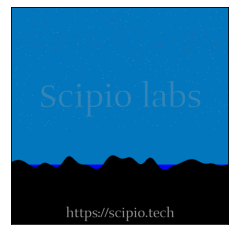

In [7]:
# Mostrar imagem
cv_show_image(image_path)

In [8]:
# Carregar Imagem
cv_image = cv2.imread(image_path)
cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB) # BGR -> RGB

### Investigar a Imagem Manualmente

O código a seguir abre uma janela que mostra toda a imagem, com a opçâo de zoom e podendno ver o código RGB para cada pixel.

Ao dar o zoom máximo podemos perceber que

+ Estrelas ==> cor branca: RGB `255, 255, 255`
+ Meteoro  ==> cor vermelha: RGB `255, 0, 0`
+ Água     ==> cor azul: RGB `0, 0, 255`

Dessa forma o desafioserá resolvido da seguinte forma
+ Contagem de piexels vermelhos e brancos, poissão respectivamente as estrelas e os meteoros
+ Encontrar o intervalo onde está a àgua e ver para cada meteoro se está emcima da água (comparando se têm o mesmo valor no eixo x)

In [9]:
# VER A IMAGEM EM UMA JANELA
# !! ABERTE ALGUM BOTÃO PARA SAIR DA JANELA,
# !! SE NÃO INTERROMPE O KERNEL

# cv_image_window = cv2.imread(image_path)
# cv2.imshow("Original", cv_image_window)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

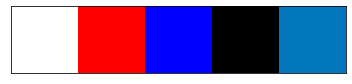

In [10]:
# Definindo as principais cores da imagem
white = [255, 255, 255]
red = [255, 0, 0]
blue = [0, 0, 255]
black = [0, 0, 0]
blue_sky = [2, 119, 189]

cv_print_list_pixels(np.array([white, red, blue, black, blue_sky]))

## Contagem de Estrelas e Meteoros

Será usado `np.unqiue` para não só contar os valores únicos como tambem o nseu número de ocorrencias. Para fazer isso altera-se o `np.array` para uma unica dimensão com `.reshape(-1,3)`.

Retorna `unique` que tem uma lista de pixels únicos e em  `counts` a contagem.

In [11]:
unique, counts = np.unique(
    cv_image.reshape(-1, 3),
    axis = 0, 
    return_counts=True
)
unique_list = unique.tolist()

In [12]:
# Observando valores de `unique` e `counts`
val = 5
print(unique[:val], '\n')
print(counts[:val])

[[  0   0   0]
 [  0   0 255]
 [  1   1   1]
 [  2   2   2]
 [  2 119 188]] 

[135875   1535    116     11     29]


A linhas 163 tem um meteoro

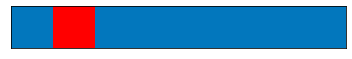

In [13]:
# 8 primeiros pixels da linha 263 (onde possui um metoro)
cv_print_list_pixels(cv_image[163][:8])

**Contando as ocorrências para branco e vermelho**

In [14]:
idx_white = unique_list.index(white)
print('Contagem de Estrelas:', counts[idx_white])

idx_red = unique_list.index(red)
print('Contagem de Meteoros:', counts[idx_red])

Contagem de Estrelas: 315
Contagem de Meteoros: 328


## Contagem de meteoros que caem na água

Após analisar a imagem usando o software `KolourPaint` (mas também pode ser feito pelo `Paint` do window) pode-se observar que:

**A superfície da água é a linha 512 da imagem**

Com essa informação fica mais fácil calcular os 5 intervalos da água, basta analisar *somente* essa linha.

In [15]:
water_line = 512

In [16]:
# Pegandos os últimos 42 pixels da linha 512 da imagem
#   aí pode-se ver um dos intervalos da superfície da água
cv_print_list_pixels(cv_image[water_line][-42:])

**Calculando os 5 intervalos da superfície da água**

In [17]:
ranges, start, end = [], '', ''

for idx, el in enumerate(cv_image[water_line]):

    is_blue = np.array_equal(el, blue)
    
    # 1 - Se encontrar terra
    if(not is_blue and not start):
        continue
    
    # 3 - Ainda está na água
    if(is_blue and start):
        continue
    
    # 4 - Sai da água: salva o intervalo e reseta as variáveis
    if(not is_blue and start):
        end = idx - 1 # último pixel de água
        ranges.append( (start,end) )
        start, end = '', ''
        continue
    
    # 2 - Começa o intervalo da água
    if( is_blue ):
        start = idx
        continue
        
print('OS {} intervalos que contém a água:\n'.format(len(ranges)))
print(ranges)

OS 5 intervalos que contém a água:

[(59, 94), (126, 160), (241, 296), (473, 533), (664, 696)]


**Cálculo do número meteoros que caem na água**

Obse: Usa-se somente parte da imagem, pois o cálculo é demorado e os meteoros somente na parte superior da image.

In [18]:
meteors_falls_water = []

# lê imagem até 352 pois a parte inferior
#   da imagem não tem meteoros
for id_y, row in enumerate(cv_image[:352, ::]):
    for id_x, pixel in enumerate(row):
        
        if(np.array_equal(pixel, red)):
            for range in ranges:
                if(id_x >= range[0] and id_x <= range[1]):
                    meteors_falls_water.append([id_x, id_y])
                    
print('Quantos meteoros vão cair na água:',
      len(meteors_falls_water))

Quantos meteoros vão cair na água: 105


# Conclusão

| Cases                        | Count |
|------------------------------|-------|
| Number of Stars              | 315   |
| Number of Meteors            | 328   |
| Meteors falling on the Water | 105   |